# Bin Packing Lab

- Authors:
  - Nabil Johny, johnyn@mcmaster.ca
  - Wajdan Faheem, Faheemw
- Group ID on Avenue: 29
- Gitlab URL: https://gitlab.cas.mcmaster.ca/johnyn/l2-bin-packing

In [ ]:
#All of the imports needed in the report

from macpacking.reader import DatasetReader, BinppReader, JburReader
from macpacking.model  import Online, Offline
from macpacking.algorithms.GreedyPartition import GreedyPartition
import macpacking.algorithms.baseline as baseline
import macpacking.algorithms.offline as offline
import macpacking.algorithms.online as online
from matplotlib import pyplot as plt
from os.path import basename, exists
from pyperf import BenchmarkSuite
from macpacking.Analysis.OptimalCompare import OptimalCompare
from macpacking.Analysis.FixedBin import FixedBin

## T1: UNDERSTAND THE CODE BASE

Some of the takeaways from the last lab were to have proper import mechanisms using “..” and “.” instead of manually editing the path. As well as being consistent with our naming convention emphasizing readability. 

The current model of the code adheres to the SOLID principles:

**Single Responsibility**

Each class has a single job, for example, the data set reader's responsibility is to load the data from the disk. Each algorithm is separated into separate classes with their purpose of bin packing. 

**Open-Closed Principle**

The code is open for extension but closed for modification. The bin packer further separates into online and offline algorithms, allowing for new algorithms to be easily added. The abstract class DatasetReader lets the user add different data readers in case the format of the dataset changes. But the current code is closed for modifications as if the new code added does not modify the current algorithms and file readers currently implemented. 

**Interface Segregation**

The code follows interface segregation as all the algorithms are under the BinPacker interface and the dataset reader segregates the file reader functions. This separates the algorithms from the dataset keeping them independent of each other.

**Dependency Inversion**

The classes presented in the code all depend on either interfaces or abstract classes. For example, each of the algorithms depends on either the Online abstract class or Offline abstract classes. Similarly, the methods of data extraction all depend on the abstract class Dataset Reader. 
 
The Dataset for binpp follows this structure:

**N**: The number after N corresponds to the number of items needed to be packed. This is important as we need to know how items in the list are left, the algorithm is not finished until the number of items remaining is 0. 

Domain = {1,2,3,4}

{Number after N: Number of items corresponds to}

{1:50, 2:100, 3:200, 4:500}

**C**: The number after C corresponds to the capacity of the bins. The capacity of the bin is important for the algorithms to work properly because it is the maximum weight that can be put in a bin.

Domain = {1,2,3}

{Number after C: Capacity of bins corresponds to}

{1:100, 2:120, 3:150}

**W**: The number after W corresponds to the size of the items. The weights of the items are important for the algorithms to work because we want to minimize the number of bins used by distributing the items in the bins based on weight.

Domain = {1,2,4}

{Number after W: The range of the weights of the items}

{1:[1,100], 2:[20,100], 3:[30,100]}

The letter at the end corresponds to 1 of 20 instances for each folder.


The way the code was set up in this lab allowed us to easily add a new dataset reader to support the cases stored in the jburkardt directory. We integrated it into the class hierarchy by creating a subclass of the abstract class Dataset Reader. We did not modify any of the base code, which is due to the open-closed nature of the class structure. 

Each data set for the jburkardt directory corresponds to 3 files, a c, s, and w file. For example, for p01, there is p01_c, p01_w and p01_s. The c file has the bin capacity, the w file stores the weights of each object, and the s has the optimal assignment of weights. To integrate it with our class structures and how current algorithms work, we needed to extract the capacity of the bins from the c file and the weights of each item from the w file. We extracted the optimal assignments as well but it is not needed as none of the algorithms utilize this parameter. Using this optimal assignment variable could allow us to implement an algorithm to sort the items based on the values. The run time for extraction is O(n) as it is dependent on the length of the CSV file.
Similarly to the new dataset reader, we were able to implement the new online terrible algorithm which uses one bin per object. We integrated this algorithm into the class hierarchy by creating a subclass of the abstract class Online. Again, we did not have to modify any of the existing code. The run time is O(n) as it iterates through each item and assigns it to its separate bin. 


In the code block below shows an example of a working jburkardt reader on the _datasets/jburkardt/p01_c.txt file: 

In [13]:
dataset = '_datasets/jburkardt/p01_c.txt'
reader: DatasetReader = JburReader(dataset)
print(f'Dataset: {dataset}')
print(f'  - Bin Capacity: {reader.offline()[0]}')
print(f'  - Objects to pack: {sorted(reader.offline()[1])}')

p01
Dataset: _datasets/jburkardt/p01_c.txt
  - Bin Capacity: 100
  - Objects to pack: [3, 7, 11, 33, 33, 33, 50, 60, 70]


The code below shows an example of the BinppReader on the _datasets/binpp/N1C1W1/N1C1W1_B.BPP.txt file:

In [19]:
dataset = '_datasets/binpp/N1C1W1/N1C1W1_B.BPP.txt'
reader: DatasetReader = BinppReader(dataset)
print(f'Dataset: {dataset}')
print(f'  - Bin Capacity: {reader.offline()[0]}')
print(f'  - Objects to pack: {sorted(reader.offline()[1])}')

Dataset: _datasets/binpp/N1C1W1/N1C1W1_B.BPP.txt
  - Bin Capacity: 100
  - Objects to pack: [8, 8, 12, 13, 13, 14, 15, 17, 18, 19, 20, 23, 30, 37, 37, 39, 40, 43, 43, 44, 44, 50, 51, 61, 61, 62, 62, 63, 66, 67, 69, 70, 71, 72, 75, 76, 76, 79, 83, 83, 88, 92, 92, 93, 93, 97, 97, 97, 99, 100]


The code below shows the terrible algorithm using the data from _datasets/binpp/N1C1W1/N1C1W1_B.BPP.txt file:

In [20]:
strategy: Online = online.TerribleFit()
result = strategy(reader.online())
print(f'nb_bins = {len(result)}')
print(f'{sorted(result)}')

nb_bins = 50
[[8], [8], [12], [13], [13], [14], [15], [17], [18], [19], [20], [23], [30], [37], [37], [39], [40], [43], [43], [44], [44], [50], [51], [61], [61], [62], [62], [63], [66], [67], [69], [70], [71], [72], [75], [76], [76], [79], [83], [83], [88], [92], [92], [93], [93], [97], [97], [97], [99], [100]]


As we can see, it created a new bin for every piece in the input stream and is not trying to optimize the number of bins.

## T2: IMPLEMENT AND BENCHMARK ALGORITHMS

The way the base code was set up allowed us to follow the SOLID principles for each of the algorithms. All the offline algorithms were integrated underneath the Offline abstract class and the online algorithms were integrated underneath the Online abstract class, following the dependency inversion principle. The offline and online algorithms are independent of each other due to the interface segregation, and we were able to easily implement them because of the open-closed nature of the base code. Each algorithm has a single responsibility.


The best KPI for testing which algorithm is optimal is the number of bins but in some cases, some of the algorithms return the same number of bins, thus we need to further analyze a way to measure KPIs related to the algorithms. Optimization of an algorithm is important, so the KPIs we decided to measure were the number of operations, iterations, accesses, comparisons, and runtime. To test these KPIs we used the binpp dataset. These benchmarking protocols are relevant because in certain machines or situations we only have a limited amount of memory or processing power. So even if a solution is the closest, if the machine cannot handle a certain amount of operations, data accesses, etc., then the machine will fail. So in some cases choosing a worse algorithm with better memory allocation and less power usage will be better. Thus the importance of this benchmarking protocol testing the KPIs listed above.


An online bin packing algorithm, makes a decision on where to place the current input without knowning the items that are yet to be streamed into it.

An offline bin packing algorithm, makes a decision on where to place the current input based on the items that are yet to be streamed into it. The algorithm "knows" the future inputs.

General Rundown of the Online Algorithms:

**First Fit**

The first fit algorithm is an offline algorithm that iterates through the list of items and assigns them to the first bin that has enough space. The algorithm is O(n) as it iterates through the list of items. 

**Best Fit**

The best fit algorithm is an offline algorithm that iterates through the list of items and assigns them to the bin that has the least amount of space left. 

**Worst Fit**

The worst fit algorithm is an offline algorithm that iterates through the list of items and assigns them to the bin that has the most amount of space left.

**Terrible**

The terrible algorithm is an online algorithm that creates a new bin for every item. The algorithm is O(n) as it iterates through the list of items.

**Offline version of each algorithm**

The offline version of each algorithm is the same algorithm, but a sorted array is passed into it instead.


The code section below shows each of the algorithm in action on the data from _datasets/binpp/N1C1W1/N1C1W1_F.BPP.txt file:

In [70]:
dataset = '_datasets/binpp/N1C1W1/N1C1W1_F.BPP.txt'
reader: DatasetReader = BinppReader(dataset)

In [27]:
strategy: Online = online.FirstFit()
result = strategy(reader.online())
print(f'nb_bins = {len(result)}')
print(f'{sorted(result)}')

nb_bins = 29
[[45, 30], [49], [49, 24, 26], [50, 11, 37, 2], [54, 36], [56, 35, 2], [57], [60, 19, 13], [60, 27], [68, 21, 11], [69], [69, 26], [70, 30], [71], [72], [73], [75, 25], [77, 14, 8], [78, 20], [83, 15], [84], [84], [89], [89], [92], [93], [98], [98], [99]]


In [28]:
strategy: Online = online.BestFit()
result = strategy(reader.online())
print(f'nb_bins = {len(result)}')
print(f'{sorted(result)}')

nb_bins = 28
[[35, 60], [45, 30, 25], [49], [50, 49], [54, 36], [56, 37], [57, 26, 13], [60, 15, 20], [68, 26], [69], [69, 30], [70, 24], [71], [72], [73, 27], [75, 21], [77, 11, 11], [78, 19, 2], [83, 14, 2], [84], [84], [89], [89], [92, 8], [93], [98], [98], [99]]


In [29]:
strategy: Online = online.WorstFit()
result = strategy(reader.online())
print(f'nb_bins = {len(result)}')
print(f'{sorted(result)}')

nb_bins = 28
[[35, 60], [45, 30, 25], [49], [50, 49], [54, 36], [56, 37], [57, 26, 13], [60, 15, 20], [68, 26], [69], [69, 30], [70, 24], [71], [72], [73, 27], [75, 21], [77, 11, 11], [78, 19, 2], [83, 14, 2], [84], [84], [89], [89], [92, 8], [93], [98], [98], [99]]


In [30]:
strategy: Online = online.NextFit()
result = strategy(reader.online())
print(f'nb_bins = {len(result)}')
print(f'{sorted(result)}')

nb_bins = 35
[[11, 49], [14, 69], [20], [21, 24], [26, 30, 13], [27], [30, 2, 19, 36], [35, 60], [37], [45], [49, 25], [50], [54, 26], [56], [57, 15, 11], [60], [68], [69], [70], [71], [72], [73, 2, 8], [75], [77], [78], [83], [84], [84], [89], [89], [92], [93], [98], [98], [99]]


In [32]:
strategy: Offline = offline.FirstFitOffline()
result = strategy(reader.offline())
print(f'nb_bins = {len(result)}')
print(f'{sorted(result)}')

nb_bins = 27
[[49], [50, 49], [54, 45], [56], [57, 35], [60, 36], [60, 37], [68, 19], [69, 24], [69, 30], [70, 30], [71, 26], [72, 26], [73, 27], [75, 25], [77, 20], [78, 21], [83, 13], [84, 14], [84, 15], [89, 11], [89, 11], [92, 8], [93], [98, 2], [98, 2], [99]]


In [33]:
strategy: Offline = offline.BestFitOffline()
result = strategy(reader.offline())
print(f'nb_bins = {len(result)}')
print(f'{sorted(result)}')

nb_bins = 27
[[49], [50, 49], [54, 45], [56], [57, 35], [60, 36], [60, 37], [68, 19, 13], [69, 24], [69, 30], [70, 30], [71, 26], [72, 26], [73, 27], [75, 25], [77, 20], [78, 21], [83], [84, 14], [84, 15], [89, 11], [89, 11], [92, 8], [93], [98, 2], [98, 2], [99]]


In [34]:
strategy: Offline = offline.WorstFitOffline()
result = strategy(reader.offline())
print(f'nb_bins = {len(result)}')
print(f'{sorted(result)}')

nb_bins = 27
[[49], [50, 49], [54, 45], [56], [57, 35], [60, 36], [60, 37], [68, 19, 13], [69, 24], [69, 30], [70, 30], [71, 26], [72, 26], [73, 27], [75, 25], [77, 20], [78, 21], [83], [84, 14], [84, 15], [89, 11], [89, 11], [92, 8], [93], [98, 2], [98, 2], [99]]


In [35]:
strategy: Offline = offline.NextFitOffline()
result = strategy(reader.offline())
print(f'nb_bins = {len(result)}')
print(f'{sorted(result)}')

nb_bins = 32
[[19, 15, 14, 13, 11, 11, 8, 2, 2], [25, 24, 21, 20], [27, 26, 26], [35, 30, 30], [37, 36], [49, 45], [50, 49], [54], [56], [57], [60], [60], [68], [69], [69], [70], [71], [72], [73], [75], [77], [78], [83], [84], [84], [89], [89], [92], [93], [98], [98], [99]]


Now moving on to the benchmarking, the following code in the sections below run the benchmarking for T2 + Refined First Fit (T4):


In [2]:
from macpacking.Analysis.Benchmark import Benchmark 

#The benchmark Class
bench = Benchmark()
#Does the benchmarking
benchOutput = bench.benchmark()


In [36]:
"""Code to run the pyperf runtime code and it needs to be seperated in order to avoid the other files from messing up
The bench.json file has already been created, so the output will not be shown, however if you wish to see it, please delete the file
and run this again. Warning: it will take 5+ minutes!
"""

if not exists('bench.json'):
    !{'pipenv run python PyperfBenchmark.py -o bench.json'}


In [37]:
#Function to load the data from the json file created by pyperf

def load_bench_measurements(file,name: str) -> list[float]:
    """extract the values for a given benchmark"""
    suite = BenchmarkSuite.load(file)
    bench = suite.get_benchmark(name)
    return sum(list(bench.get_values()))/len(list(bench.get_values()))

In [38]:
#The algorithms used in the benchmarking
algos = [("NextFit", "_NF"), ("FirstFit", "_FF"), ("BestFit", "_BF"),
        ("WorstFit","_WF"), ("TerribleFit", "_TF"), ("NextFitOffline","_NFO"), 
        ("FirstFitOffline","_FFO"), ("BestFitOffline","_BFO"), 
        ("WorstFitOffline","_WFO"), ("RefinedFirstFit", "_RFF")]

#Adds the runtime for each algorithm and file
for i in bench.cases:
    i = basename(i)
    for name in algos:
        benchOutput[name[0]]["runtime"][i] = load_bench_measurements("bench.json", i + name[1])


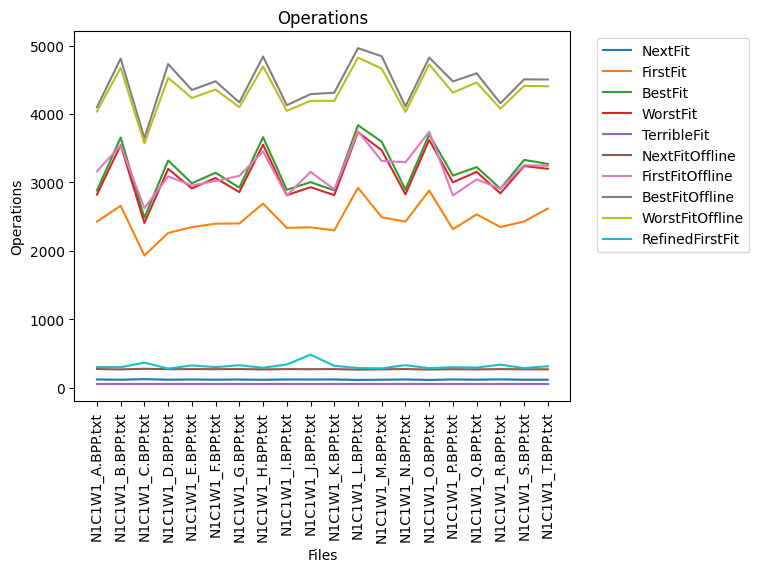

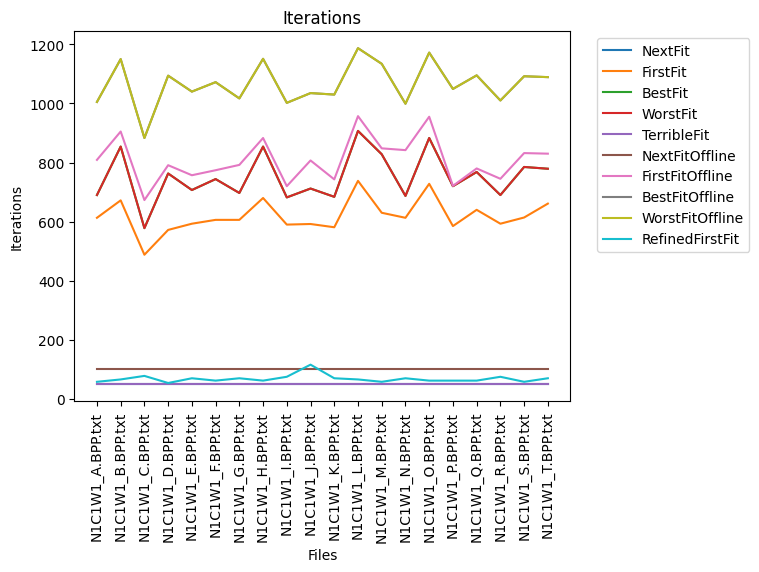

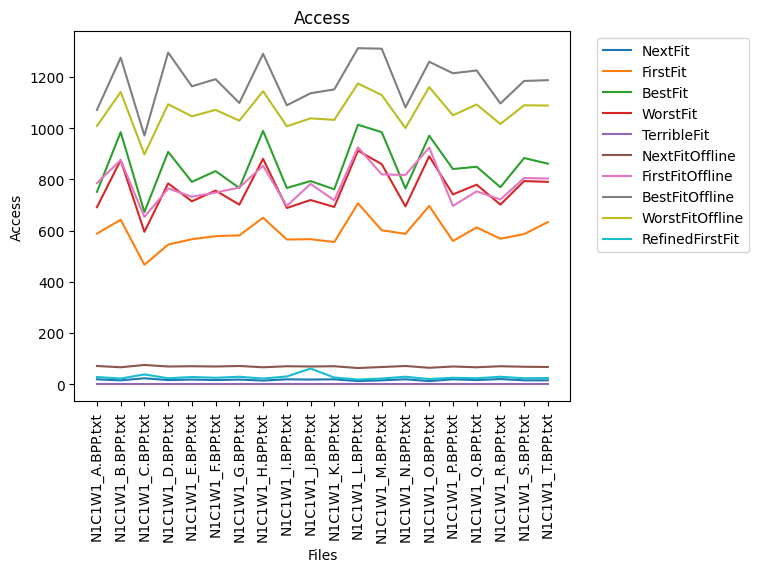

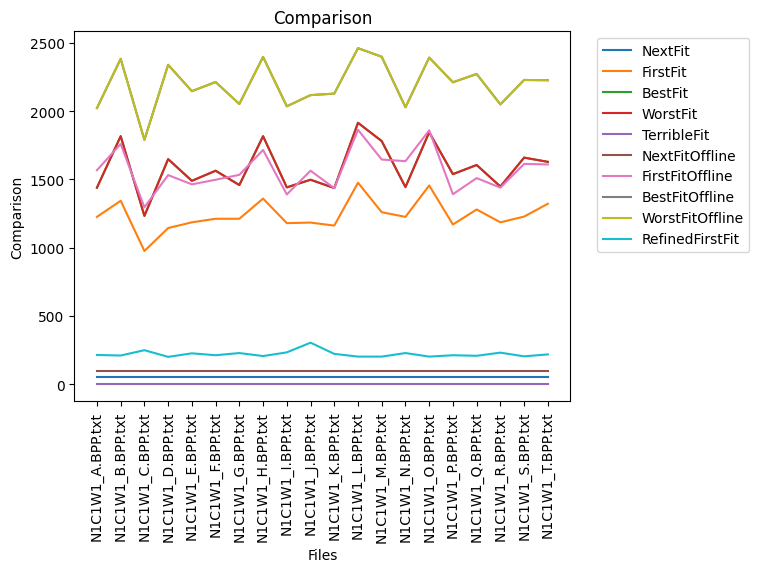

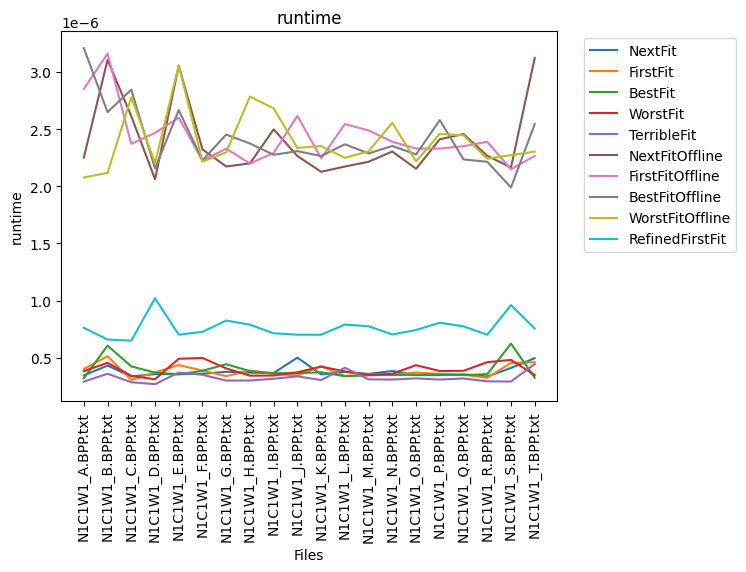

In [39]:
#Graphs the benchmark data for each algorithm and file
def graphBenchMark():
    
    for key in benchOutput["FirstFit"].keys():
        
        for name in benchOutput.keys():

            plt.xlabel('Files')
            plt.xticks(rotation = 90)
            plt.ylabel(key)
            plt.title(key)
            plt.plot([basename(x) for x in bench.cases], [
                x for x in benchOutput[name][key].values()], '-', label=name)
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        plt.show()
    
graphBenchMark()

First, let's begin with runtime, the offline algorithms, and online algorithms had similar run times respectively. But the offline was much faster, almost by 2 seconds. This makes sense since the online algorithms have to wait for their stream of input. 


Before moving on to the next KPIs, we will briefly touch upon the O notation for each. NextFit runs at O(n) as packing an object is done in constant time. For FirstFit, in the worst case, a new bin has to be accessed each time a new object is inserted, leading to an O(n^2). The way we have implemented BestFit and WorstFit is in O(n^2) time but if we would have used a self-balancing binary search tree or a heap we could have implemented it in O(N log N).


Now looking at the Operations graph we can see that BestFitOffline, WorstFitOffline, and FirstFit have the most amount of operations which makes sense as their runtime is the longest of all (Note: BestFit and WorstFit are higher than FirstFit). The BestFit, WorstFit, and FirstFit are almost the same as their offline versions except they are a bit lower since we must sort the array in the offline versions leading to more operations. The worst algorithms in terms of getting close to the optimal values were terrible fit, and offline and online next fit and they have the lowest number of operations since their runtime is linear. This trend continues for the remaining graphs, for Iterations, Data Accesses, and Comparisons. 


After analyzing the number of bins used by each algorithm with a corresponding case we can use these KPIs to see which is the best. Referring to the graph in the next section called Bins, we can see that for the Offline and Online algorithms, Best Fit, Worst Fit, and First Fit perform the best, coming closest to the optimal solution the most times (BestFit and WorstFit are slightly ahead). If we analyze these algorithms based on the previous KPIs we can see that BestFit has the most, followed by WorstFit, then FirstFit. So depending on what is more important the memory and processing usage or closer to the correct answer you can pick any of these. But, in this case, we value the closest to the optimal solution the most, and based on the dataset we analyzed, WorstFit offline has slightly fewer operations, and data accesses, leading us to believe it to be performing the best.



## T3: MEASURE IMPROVEMENT MARGIN

As we know the optimal number of bins for each case, in T3 we tackle the problem of measuring the margin of improvement for each case. We chose cases from each folder to test the different algorithms since files in the same folder have the same characteristics. We evaluated the margin by analyzing if the optimal solution was found or not and by how many bins. 


In the OptimalCompare.py file, we have our class OptimalCompare which uses all the algorithms needed to be compared against the optimal solution. The run time for the measure function (where the main action occurs) is O(n^2) as it iterates through each algorithm and for each algorithm it tests and stores the result for each case which we use to graph later and tells us if the optimal solution is found or not. 


We plotted these results to analyze which algorithms performed best. We have 3 graphs plotted, first is the Difference graph which compares the difference of bins used between each algorithm and optimal. Next is the Bins graph which shows how many bins each algorithm uses and finally the Percent graph which shows the percentage of success rate compared to optimal for each algorithm. 

The code section below shows the comparisons of each algorithm to the optimal solution:


In [42]:
#Creates an instance of our benchmarking data for T3
T3Data = OptimalCompare()
#Calls the measure function
T3Data.measure()
#collects all of the data
data = T3Data.compareData


BenMaierOffline
For case:  N1C1W1_A BenMaierOffline the Bins is:  25  and the optimal Bins is:  25
The optimal Bins is not found
For case:  N1C1W4_B BenMaierOffline the Bins is:  40  and the optimal Bins is:  40
The optimal Bins is not found
For case:  N1C2W2_C BenMaierOffline the Bins is:  29  and the optimal Bins is:  29
The optimal Bins is not found
For case:  N1C3W1_D BenMaierOffline the Bins is:  19  and the optimal Bins is:  19
The optimal Bins is not found
For case:  N1C3W4_E BenMaierOffline the Bins is:  23  and the optimal Bins is:  23
The optimal Bins is not found
For case:  N2C1W2_F BenMaierOffline the Bins is:  65  and the optimal Bins is:  65
The optimal Bins is not found
For case:  N2C2W1_G BenMaierOffline the Bins is:  45  and the optimal Bins is:  45
The optimal Bins is not found
For case:  N2C2W4_H BenMaierOffline the Bins is:  61  and the optimal Bins is:  61
The optimal Bins is not found
For case:  N2C3W2_I BenMaierOffline the Bins is:  45  and the optimal Bins is:  

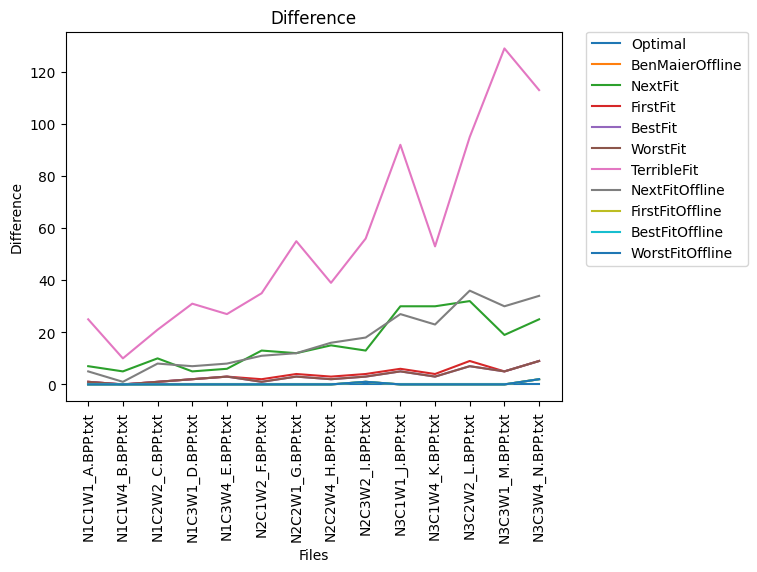

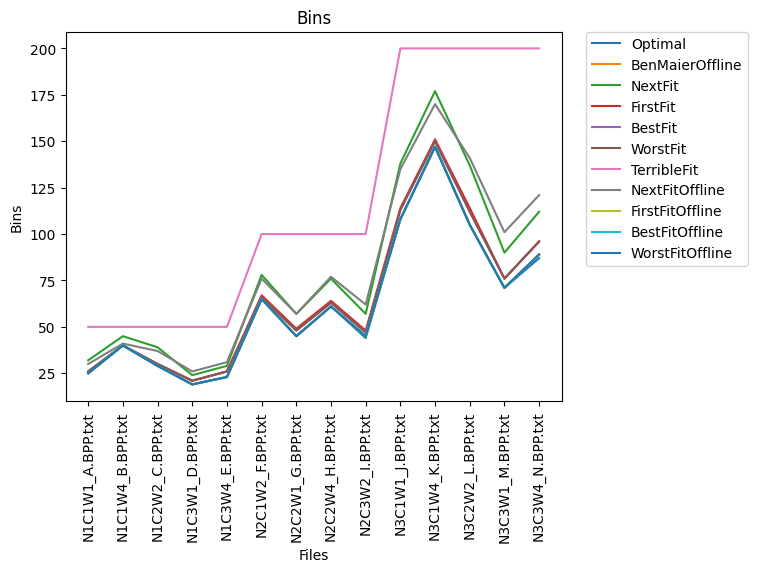

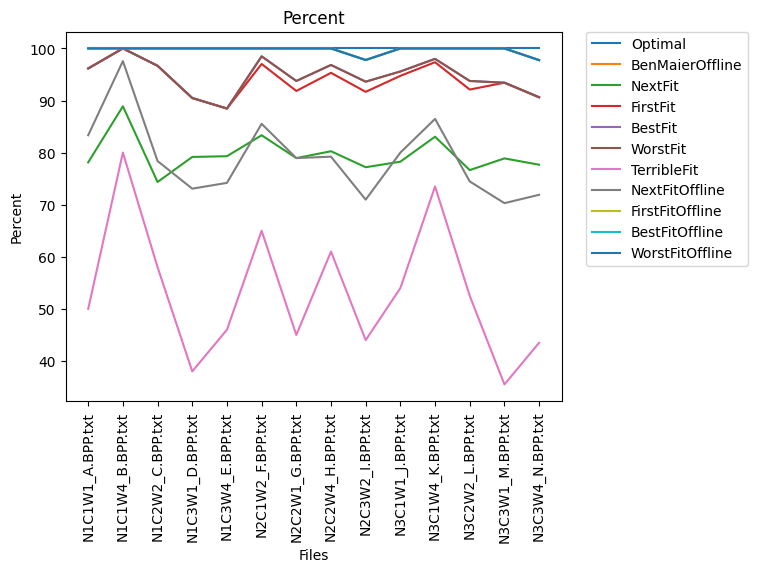

In [43]:
#Graphs the data presented in the data variable above
def graphT3():
    for i in data["Optimal"].keys():
        for j in data.keys():
            plt.xlabel('Files')
            plt.xticks(rotation = 90)
            plt.ylabel(i)
            plt.title(i)
            plt.plot([basename(x) for x in T3Data.cases], [
                x for x in data[j][i].values()], '-', label=j)
        plt.xticks(rotation=90)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.show()
graphT3()

The percent graph allows us to see the problematic cases the best. Apart from best fit, worst fit, and baseline, we can see a general trend amongst the other algorithms. The higher the capacity of the bins the lower these algorithms succeed compared to the optimal. When testing for cases with C3 (capacity = 150) the algorithms are at their lowest valleys. Best Fit, Baseline, and Worst Fit seemed to reach the optimal value almost 100% of the time except for N2C3W2 and N3C3W4 suggesting that for very large numbers of items and large capacity with heavier items these algorithms are struggling as well. These trends are likely due to the memory allocation and processing power each algorithm needs (especially for best fit), as the larger, the numbers are they tend to perform worse.  


## T4: ADD SMARTER ALGORITHMS

**General Information about Refined First Fit**:


The refined first fit algorithm partitions the item sizes into four ranges: class A - (1/2,1], class B - (2/5, 1/2], class C - (1/3, 2/5], and class D - (0,1/3]. We assign these same sizes to 4 bins. From here, the way the algorithm works is the item in the input stream is first divided by the bin capacity to get the ratio of how much the item will fill up the bin. The piece is then placed inside the bin where the ratio is allowed in a first-fit manner. However, if a piece that is between (1/3, 2/5] appears in a multiple of 6, 7, 8, or 9, it will be added to Class A instead. This pattern continues until a bin is full and then a new one for that class is opened. Once all of the inputs have been processed, the algorithm returns the nested list. [1]


This algorithm is not classified as an Any-Fit algorithm since a new bin can be opened although the current item fits inside an open bin. The algorithm is classified as an online algorithm since it can process the items as they arrive [1].


**Analysis in comparison to other Algorithm**:


In terms of runtime, the refined first fit algorithm performs up to 3 times better than the offline but is slower by up to 2 times slower than the online algorithms. This is because the input stream does not need to be sorted first before getting fed into the algorithm, so it will outperform the offline, but it requires a lot more computation to decide where to place the items.


Furthermore, in terms of the number of iterations operations done by the algorithm, the refined first fit beats most of the other ones because it does not need to iterate over the whole solution to determine where the piece goes. In the worst case, the algorithm does (4 + (# of class A bins)*(# of class C multiple of 6,7,8 or 9)), while other algorithms have to iterate over a big portion (sometimes even the entirety) of the solution array to place the item. 


Moreover, in terms of comparisons, the algorithm outshines most of the previously implemented because of a similar reason mentioned above for iterations. Since a large number of iterations is not necessary to append an item to a bin, we do not need to compare the sum of the bin to the piece to determine if it is acceptable or not. This will overall reduce the total number of iterations required for the refined first fit algorithm. This general pattern applies to the other benchmarks as well. 


In order to see the results for this graphed, please look at the graphs in T2 as this algorithm is included in there.

[1] https://en.wikipedia.org/wiki/First-fit_bin_packing#refined


The code block below shows the refined first algorithm running using the _datasets/binpp/N1C1W1/N1C1W1_F.BPP.txt file:

In [45]:
strategy: Online = online.RFF()
result = strategy(reader.online())
print(f'nb_bins = {len(result)}')
print(f'{sorted(result)}')


nb_bins = 33
[[11, 21, 24, 26, 14], [25, 27, 20], [26, 30, 13, 2, 8], [30, 2, 19, 15, 11], [36], [37, 35], [45, 49], [50, 49], [54], [56], [57], [60], [60], [68], [69], [69], [70], [71], [72], [73], [75], [77], [78], [83], [84], [84], [89], [89], [92], [93], [98], [98], [99]]


## T5: FROM FIXED CAPACITY TO FIXED BINS

The next challenge was to implement a variant of this bin packing problem where the goal is to balance the weight over a fixed number of bins. The baseline method was integrated into the mackpacking library. 


The algorithm we implemented used a greedy method to attack this multi-way number partitioning problem. The way we have implemented the code follows the SOLID principles and respects encapsulation. It takes a list of items with the number of bins and first sorts them in descending order. Then starting with the first bin it goes through the list and places each item into the bin with the smallest sum of items. The runtime should be about O(n). It is a straightforward methodology to balance the bins but we will compare the KPIs with the baseline to see how well it works. 


The main KPI previously measured was the number of bins for the solution, this KPI is not adequate for the current problem as we will always have a fixed number of bins. The other KPIs, data accesses, operations, etc. would be useful to compare different algorithms. Unfortunately, we cannot measure these KPIs for this imported library method. We can still compare the runtime of the imported algorithm, thus the code for measuring the run time can be reused. 


For the new problem, the KPIs we decided to measure was the max and the min of the total weight of each bin. As well as the difference between them. In an ideal scenario, when all the weight is evenly distributed amongst the bins, the difference between the max and min should be 0 if not very close. Essentially, the closer to 0, the better the algorithm. 


The code block below shows the baseline algorithm running using the _datasets/binpp/N1C1W1/N1C1W1_F.BPP.txt file:


In [71]:
greed = GreedyPartition()
result = greed((5,reader.offline()[1]))
greed.printBins()

Bin 0 [99, 83, 77, 69, 54, 50, 30, 25, 13, 11] sum: 511
Bin 1 [98, 84, 75, 69, 57, 49, 30, 24, 15, 8] sum: 509
Bin 2 [98, 84, 73, 70, 60, 45, 35, 21, 14, 11] sum: 511
Bin 3 [93, 89, 72, 71, 60, 37, 36, 26, 20, 2] sum: 506
Bin 4 [92, 89, 78, 68, 56, 49, 27, 26, 19, 2] sum: 506


The code section below will show the graphing of the algorithm and compare it to the baseline:

In [58]:
#Get the benchmarking class
fixedBin = FixedBin()
#benchmark the two algorithms
fixedBinOutput = fixedBin.benchmark()

In [59]:
"""Code to run the pyperf runtime code and it needs to be seperated in order to avoid the other files from messing up
The fixed.json file has already been created, so the output will not be shown, however if you wish to see it, please delete the file
and run this again. Warning: it will take 5+ minutes!
"""
if not exists('fixed.json'):
    !{'pipenv run python PyperfFixedBinBench.py -o fixed.json'}
    

In [60]:
#The aglorithms
algos = [("GreedyPartition", "_GP"),("Baseline","_B")]

#Extracts the runtime for each case from the fixed.json f
for i in fixedBin.cases:
    i = basename(i)
    for name in algos:
        fixedBinOutput[name[0]]["runtime"][i] = load_bench_measurements("fixed.json", i + name[1])

In [61]:
#graphs the result
def graphFixedBin():
    for i in fixedBinOutput["GreedyPartition"].keys():
        for j in fixedBinOutput.keys():
            plt.xlabel('Files')
            plt.xticks(rotation = 90)
            plt.ylabel(i)
            plt.title(i)
            plt.plot([basename(x) for x in fixedBin.cases], [
                x for x in fixedBinOutput[j][i].values()], '-', label=j)
        plt.xticks(rotation=90)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.show()
graphFixedBin()

Looking at the graph Difference, we can see that the Baseline algorithm is much closer to 0 in all the cases than our algorithm meaning the Baseline balances the weight amongst the bins much better. 

The runtime of the baseline also appears to be a lot faster but the difference in their speeds is very small so it is not as significant as the previous KPI. 

## Testing

The testing was done on each reader to see if the output matched what we expected.

For the algorithms, most of the testing came from the fact that each bin must not exceed the capacity. The code looks short, however it achieves a lot as it checks the bin for each algorithm when ran against all the files in the './_datasets/binpp/N1C1W1' directory. The testing for the greedy implemention for T5 was also done by checking if the output was what we expected froma wide variety of test cases. 

## Self-reflection questions

Wajdan Faheem:

  - What process did you go through to produce this result? (Backward)

This was the second project of the semester and I felt a lot more ready after previous one because I was more familiar with python and how to benchmark. This allowed me to work more efficently and fix bugs a lot faster.

  - What were your standards for this piece of work? Did you meet your standards? (Inward)

My standards for this lab was to produce high quality graphs which displaced all of the KPIs and the correct data in a organized manner. By making the data vault where I kept all of the results from benchmarking and all other things organized and modular, all I had to do was run a couple of for loops to output multiple graphs with minimal code. 

  - What the one thing you particularly want people to notice when they look at your work? (Outward)

Something I want people to notice is the attention to detail in the data collecting structure. Everything is localized in one area, and you don't have to go through multiple lists or dictionaries to find the data you need. If you want the comparisons for two algorithms, it'll be in the same dictionary.
  
  - What lessons will you keep from this reading/lecture in your professional practice? (Forward)

  Some lessons I will keep is knowning how to utilize external research papers when trying to figure out the solutions to the problems. When I was going through T4, I did not understand how the algorithm worked, so I went to the wiki page the profressor linked and read it very carefully to understand. These external sources can always help understand complex problems. I also cited the information taken from the wiki. 

  Nabil Johny:

I went through the process of working with my partner through many hours of researching this problem first to understand how the algorithms work then actual implementing them and using our benchmark knowledge from last lab we were able to use it here.
I have not done these type of algorithms in the past so I had nothing to compare to. But my standards are always to put my best effort no matter what and which is what I did. Even in times when the code wasn’t working and wanted to give up, I pushed through with the help of my partner. 
I really want people to notice the effort we put into benchmarking and our analysis of the code. To do the analysis we had to understand the problem at hand, it was a little difficult for me to understand all the algorithms at the start so I had to research to learn. We put a lot of effort into the whole project and would really like people to view the whole thing.
If we could do this project again, I would allocate as much time as possible in weeks 1 and 2 because in week 3 the assignments from the other classes build up and was a stressful especially the last week of working on this project.